## Cubic splines by hand

In [1]:
import sympy as sym
from sympy.functions.elementary.piecewise import Piecewise

def natcubic_hardcoded(x):
    h = 0.5; vecx = [0.,0.5,0.]
    a = [0,1,0]; c = [0,-3/(2*h**2),0]
    d = [-1/(2*h**3), 1/(2*h**3)]; b = [3/(2*h), 0]
    terms = lambda x,i: a[i]+b[i]*(x-vecx[i])\
                        +c[i]*(x-vecx[i])**2\
                        +d[i]*(x-vecx[i])**3
    spline = Piecewise((terms(x,0), 0<=x<0.5),\
                           (terms(x,1),0.5<=x<=1))
    return spline

def natcubic_hardcoded_terms(x,i):
    h = 0.5; vecx = [0.,0.5,0.]
    a = [0,1,0]; c = [0,-3/(2*h**2),0]
    d = [-1/(2*h**3), 1/(2*h**3)]; b = [3/(2*h), 0]
    terms = lambda x,i: a[i]+b[i]*(x-vecx[i])\
                        +c[i]*(x-vecx[i])**2\
                        +d[i]*(x-vecx[i])**3
    return terms(x,i)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
stip = np.linspace(0,1)
plt.plot(stip,[natcubic_hardcoded(t) for t in stip])
plt.title("Two basic cubic splines")
plt.show()

In [3]:
x = sym.Symbol('x')
s0 = natcubic_hardcoded_terms(x,0)
s1 = natcubic_hardcoded_terms(x,1)
ds0 = sym.diff(s0,x)
ds1 = sym.diff(s1,x)
d2s0 = sym.diff(s0,x,2)
d2s1 = sym.diff(s1,x,2)

# test for continuity of s, s', and s''
print(s0.subs(x,0.5) == s1.subs(x,0.5))
print(ds0.subs(x,0.5) == ds1.subs(x,0.5))
print(d2s0.subs(x,0.5) == d2s1.subs(x,0.5))

# test boundary conditions
print(d2s0.subs(x,0)==0, d2s1.subs(x,1)==0)

TypeError: not able to determine a substitution from x

## Buggy interpolation

In [ ]:
import numpy as np

x=np.array([0.0, 0.5, 1.0, 1.5, 1.7, 1.85, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 5.75, 6.0])
y=np.array([0.0, 0.9, 1.2, 1.35, 1.4, 1.7, 1.95, 2.3, 2.35, 2.4, 2.35, 2.25, 1.8, 1.0, 0.7, 0.0])
v=np.array([0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0])
w=np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.45, 0.6, 0.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.45, 0.6, 0.45, 0.0, 0.0, 0.0, 0.0, 0.0])

from scipy.interpolate import CubicSpline, lagrange
ptop=lagrange(x,y)
pbot=lagrange(v,w)
ctop=CubicSpline(x,y)
cbot=CubicSpline(v,w)

stip = np.linspace(0,6, 500)
plt.plot(stip,ptop(stip), color="Red")
plt.plot(stip,pbot(stip), color="Orange")
plt.scatter(x,y, color="Black")
plt.scatter(v,w, color="Black")
plt.axis([-0.5,6.5,-0.5,3])
plt.ylabel("Buggy height")
plt.title("Minimal degree polynomial interpolation")
plt.grid()
plt.show()

plt.plot(stip,ctop(stip), color="Red")
plt.plot(stip,cbot(stip), color="Orange")
plt.scatter(x,y, color="Black")
plt.scatter(v,w, color="Black")
plt.axis([-0.5,6.5,-0.5,3])
plt.title("Cubic spline (not-a-knot) interpolation")
plt.ylabel("Buggy height")
plt.grid()
plt.show()

It is visually apparent that the Cubic spline interpolant is more accurate (there's even floating point arithmetic error for the Lagrange interpolant `pbot`). This is because, near the ends of the graph, the $\prod_{i \in S} (x-x_i)$ terms contribute wild oscillations to the Lagrange interpolating polynomial.

## Error in numerical quadrature

### Degree of precision for trapezoidal & Simpson's rule

Consider $f \in C^4[a,b]$. The composite trapezoidal rule for quadrature has error $e_T$ given by some multiple of $f^{(2)}(\xi)$ for $\xi \in [a,b]$, and likewise, composite Simpson's rule has error $e_S$ equal to some multiple of $f^{(4)}(\xi)$. For any polynomial $p_1$ of degree $1$, we have $p_1^{(2)} \equiv 0$ and thus $e_T = 0$. Similarly, for $p_3$ of degree $3$ we have $p_3^{(4)} \equiv 0$ and thus $e_S = 0$. So the trapezoidal rule has linear precision and Simpson's rule has cubic precision.

### Finding panel size to bound error

Let $f \in C^\omega$ with $f(x) = e^{-x}\sin x$. Consider the restriction of $f$ to the domain $[0,2\pi]$. For composite numerical quadrature:

- $e_T(h) = \frac{\pi h^2}{6} \max_{\xi \in [0,2\pi]}\left\lvert -2e^{-\xi}\cos \xi \right\rvert = \frac{\pi h^2}{6} \sqrt{2}e^{-3\pi/4}$.
- $e_S(h) = \frac{\pi h^4}{90} \max_{\xi \in [0,2\pi]}\left\lvert -4e^{-\xi}\sin \xi \right\rvert = \frac{\pi h^4}{90} 2\sqrt{2}e^{-\pi/4}$.

To bound the error below $10^{-4}$, we take the greatest $h = \frac{2\pi}{n}$ (with $n \in \mathrm{N}$):

- $n_T = \text{ceil}\left(2\pi \left(10^{-4} \frac6\pi \left(\sqrt{2}e^{-3\pi/4}\right)^{-1}\right)^{1/2}\right) = 167$.
- $n_S = \text{ceil}\left(2\pi \left(10^{-4} \frac{180}{\pi} \left(2\sqrt{2}e^{-\pi/4}\right)^{-1}\right)^{1/4}\right) = 29$.

With the number of panels $n$, the number of function evaluations required for numerical quadrature is $n+1$: so we'd need $168$ evaluations for the composite trapezoidal rule and $30$ for composite Simpson's.

#### Aside

Reaching this section in the assignment, I've decided to change my tone and writing style. The remainder of this assignment (and the next) will largely be written with a mind to *implementation*. I will attempt as often as possible to import packages from the copious body of code already written and optimized to quickly solve the specific problems raised in the homework.

Before launching into it, I do want to acknowledge that *implementation* has it's place in three activities of scientific computing: *learning*, *implementing* and *gaining mastery*. 

From Mary L. Boas, *Mathematical Methods in the Physical Sciences*, 2008:

> A very effective way to study a new technique is to do some simple problems by hand in order to understand the process, and compare results with a computer solution. 

From [“1.5. Scipy : high-level scientific computing — Scipy lecture notes”](http://www.scipy-lectures.org/intro/scipy.html). Retrieved July 30, 2018.

> Before implementing a routine, it is worth checking if the desired data processing is not already implemented in Scipy. As non-professional programmers, scientists often tend to re-invent the wheel, which leads to buggy, non-optimal, difficult-to-share and unmaintainable code. 


From [“Skills - Ciro Santilli”](http://www.cirosantilli.com/skills/). Retrieved July 30, 2018.

> I have to constantly stop myself from understanding every software I touch down to the assembly level. On weekends however, I make a concession to this rule. I have sworn not to go into the electronics level, but I want to break that promise some day.

Pedagogically, it's not clear to me which activity comes first. Learning? Implementing? Certainly not gaining mastery? But even mastery is motivated by a desire to learn deeply, so starting with the goal of attaining mastery is not a bad idea.

Regardless, I am now even more constrained for time and "the code has to ship".

### Implementation

Using the number of panels in the last part of the problem (matched to their respective methods) we approximate the integral numerically.

In [7]:
from scipy.integrate import trapz, simps
f = lambda x: np.exp(-x)*np.sin(x)
vecx = np.linspace(0, 2*np.pi, 168)
# composite trapezoidal
trapz(f(vecx), vecx)

0.49894854154999768

In [8]:
vecx = np.linspace(0, 2*np.pi, 30)
# composite simpsons
simps(f(vecx), vecx)

0.49828410040783189

In [9]:
# here's the antiderivative
F = lambda x: -0.5*np.exp(-x)*(np.sin(x) + np.cos(x))
# by the FTC I we have the exact value
F(2*np.pi) - F(0)

0.49906627863414599

## Rate of convergence

In [11]:
en = np.array([5**(-n**2) for n in range(14)])
en

array([  1.00000000e+000,   2.00000000e-001,   1.60000000e-003,
         5.12000000e-007,   6.55360000e-012,   3.35544320e-018,
         6.87194767e-026,   5.62949953e-035,   1.84467441e-045,
         2.41785164e-057,   1.26765060e-070,   2.65845599e-085,
         2.23007452e-101,   7.48288838e-119])

([<matplotlib.axis.XTick object at 0x7f2bbd2b3250>,
 <a list of 14 Text xticklabel objects>)

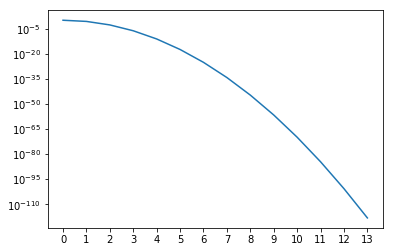